In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import pickle
import emcee
import time as ti
from tqdm import tqdm

from Spitzer_ulens import data_config
from Spitzer_ulens.MuLensEvent import MuLensEvent
from Spitzer_ulens import models
from Spitzer_ulens import PLD
from Spitzer_ulens import plot

In [2]:
# Defining final variables
EVENT_NAME = 'ob171140'
TELESCOPE = 'spitzer'
EVENT_COORDS = ('17:47:31.93','-24:31:21.6')

### Configuration and Preparation

In [3]:
load_pkl_from_file = True
load_centroid_from_file = True

if load_pkl_from_file and load_centroid_from_file:
    # Load event object from pre-existing pickle file
    filename = 'data/'+EVENT_NAME+'/PLD_input/'+EVENT_NAME+'_'+TELESCOPE+'.pkl'
    with open(filename, 'rb') as input:
        event = pickle.load(input)
else:
    if load_centroid_from_file:
        # Load centroid data from pre-existing centroid.out file
        AOR,TIMES,XDATA,YDATA,CBCD,CBUNC = data_config.load_centroid_data(EVENT_NAME,TELESCOPE)
    else:
        # All data should be downloaded into src_dir directory
        src_dir = 'data'
        # Configure directory structure for use with data_config functions
        data_config.directory_config(EVENT_NAME,TELESCOPE,src_dir)
        # Retrieve raw centroid data
        AOR,TIMES,XDATA,YDATA,CBCD,CBUNC = data_config.get_centroid_data(EVENT_NAME,TELESCOPE,EVENT_COORDS,timerange=(0,8000))
    # Obtain centroid pixel coordinates
    XCENT,YCENT = data_config.target_central_px(XDATA,YDATA)
    # Obtain 5-by-5 images and image errors
    IMG,IMG_E = data_config.target_image_square(EVENT_NAME,XCENT,YCENT,CBCD,CBUNC)
    # Create and save event object
    event = MuLensEvent(EVENT_NAME,TELESCOPE,AOR,TIMES,XDATA,YDATA,IMG,IMG_E)
    event.save()

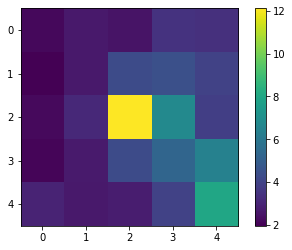

In [4]:
# Plotting an example of a 5-by-5 image
fig,ax = plt.subplots()
im = ax.imshow(event.IMG[1][40])
fig.colorbar(im)
plt.show()

### LM Fit

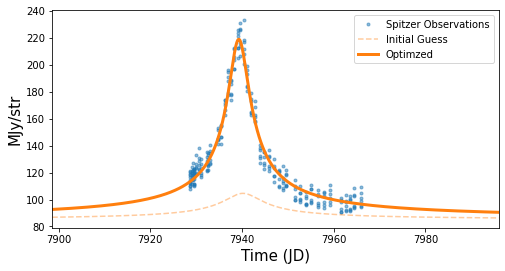

In [5]:
# Obtain raw photometry and errors
PTOT,PTOT_E = event.aperture_photometry()
# Make an initial guess for model parameters, which will be used as starting point for LM fit
p0 = np.array([84.86,7940.195,19.707,14.58]) #fb, t0, fs, tE
# Perform LM fit and plot resulting curve
popt,perr,bestfit,resi_pre,timeplot,lcoptim = event.lmfit(models.single_lens,p0,PTOT,makeplots=True)

### Solving PLD Coefficients Analytically

RMS before  :  6.895853753437509
RMS after  :  1.653753480578603


(<Figure size 576x648 with 3 Axes>,
 array([<AxesSubplot:ylabel='Photometry (MJy/str)'>,
        <AxesSubplot:ylabel='Photometry (MJy/str)'>,
        <AxesSubplot:xlabel='Time (JD)', ylabel='Residuals (MJy/str)'>],
       dtype=object))

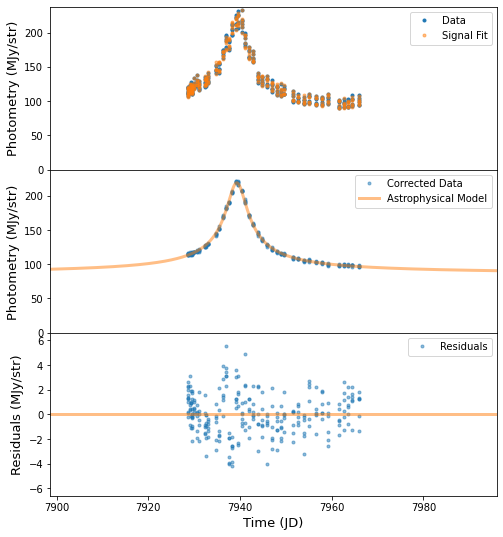

In [6]:
# Get fractional flux
PNORM = event.get_PNORM()
# Solve for PLD coefficients analytically
Y, Astro, Ps, A, C, E, X = PLD.analytic_solution(event.TIMES, PTOT, PTOT_E, PNORM, popt, models.single_lens)
# Get detector model and divide it out to get new best-fit
FIT, SYS, CORR, RESI = PLD.get_bestfit(A, Ps, X, PTOT, Astro)
# Flatten results for plotting
time,ptot,ptot_e,corr,resi,fit,sys = event.chrono_flatten(PTOT,PTOT_E,CORR,RESI,FIT,SYS)
# Compute RMS error before and after
RMS_before, RMS_after = PLD.get_RMS(resi_pre,label='RMS before',visual=True), PLD.get_RMS(resi,label='RMS after',visual=True)
# Plot corrected data, corrected model, and residuals
plot.plot_analytic_solution(time, ptot, fit, corr, resi, timeplot, lcoptim)

### MCMC fit for PLD Parameters

In [7]:
PLD_coeffs = np.empty((0,np.size(X)))
sampler = PLD.get_MCMC_sampler(popt,models.single_lens,event.TIMES,PTOT,PTOT_E,PNORM,PLD_coeffs)
pos0 = [p0*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) for i in range(sampler.nwalkers)]
sampler.reset()

In [8]:
#First burn-in:
tic = ti.time()
print('Running burn-in')
niter=300
for pos1, prob, state in tqdm(sampler.sample(pos0, iterations=niter),total=niter):
    pass

print("Mean burn-in acceptance fraction: {0:.3f}"
                    .format(np.mean(sampler.acceptance_fraction)))
sampler.reset()
toc = ti.time()
print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))

Running burn-in


300it [05:29,  1.10s/it]

Mean burn-in acceptance fraction: 0.502
MCMC runtime = 5.48 min



In [10]:
#Second burn-in
#Continue from best spot from last time, and do quick burn-in to get walkers spread out
tic = ti.time()
print('Running second burn-in')
pos2 = pos1[np.argmax(prob)]
# slightly change position of walkers to prevent them from taking the same path
pos2 = [pos2*(1+1e-6*np.random.randn(sampler.ndim))+1e-6*np.abs(np.random.randn(sampler.ndim)) for i in range(sampler.nwalkers)]
for pos2, prob, state in tqdm(sampler.sample(pos2, iterations=300)):
    pass
print('Mean burn-in acceptance fraction: {0:.3f}'
                    .format(np.median(sampler.acceptance_fraction)))
sampler.reset()
toc = ti.time()
print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))

Running second burn-in


300it [18:35,  3.72s/it]

Mean burn-in acceptance fraction: 0.584
MCMC runtime = 18.59 min



In [ ]:
#Run production
#Run that will be saved
tic = ti.time()
# Continue from last positions and run production
niter = 1000
print('Running production')
for pos3, prob, state in tqdm(sampler.sample(pos2, iterations=niter),total=niter):
    pass
print("Mean acceptance fraction: {0:.3f}"
                    .format(np.mean(sampler.acceptance_fraction)))
toc = ti.time()
print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))

Running production


 73%|███████████████████████████▋          | 727/1000 [1:39:01<43:08,  9.48s/it]

In [ ]:
#Saving MCMC Results
savepath  = 'data/'+ evt + '/mega_MCMC/'
if not os.path.exists(savepath):
    os.makedirs(savepath)
    
# path + name for saving important MCMC info
pathchain = savepath + 'samplerchain.npy'
pathposit = savepath + 'samplerposit.npy'
pathlnpro = savepath + 'samplerlnpro.npy'
pathPLDco = savepath + 'PLD_chain.npy'

# chain of all walkers during the last production steps (nwalkers, nsteps, ndim)
np.save(pathchain, sampler.chain)
# position of all 100 walkers (nwalkers, ndim)
np.save(pathposit, pos3)
# lnprob for all position of the walkers (nwalkers, nsteps)
np.save(pathlnpro, sampler.lnprobability)

# save PLD coefficients too 
np.save(pathPLDco, PLD_coeff)

In [ ]:
# saving chain ()
chain = sampler.chain
# reshaping chains to build posterior distribution
samples = chain.reshape((-1, ndim))
# getting most probable param values
(MCMC_Results) = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))))
p0_mcmc        = np.median(samples, axis=0)